Putting it all together

In [1]:
import numpy as np
from glm import BernoulliGLMPyTorch
import pandas as pd
import pickle
import os

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Parameters

In [2]:
source_folder = './sim/save/pagsim_w_stimuli_600s_inh32/'
is_simulation = True
use_sparse_tensor = True
has_inh = True
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]
bin_size = 0.001
n_PAG_to_use = 1
_range = 200 # ms
train_start = 0
train_end = 500
test_start = 500
test_end = 600
history = 10
max_lag = 10

Loading files and pre-convolution

In [ ]:
if is_simulation:
    all_timings, _total_length, conns = extract_all_simulation_timings(source_folder, has_inh, brain_regions)
    n_neurons_per_group = np.load(source_folder+'n_neurons_per_group.npy')
    # n_neurons_per_group_exc_ihn = np.load(source_folder+'n_neurons_per_group_exc_inh.npy')
    n_neurons_per_group_exc_ihn = np.array([64, 1,
                                        64, 6,
                                        64, 4,
                                        64, 10,
                                        64, 11])
    pag_df = extract_sim_as_df(source_folder, 'PAG')
    pag_timings = extract_timings(pag_df, 'PAG')
else:
    raise NotImplemented

_random_start = np.random.randint(55000-_range)
    
try:
    presyn_binned = torch.load(source_folder+'presyn_binned_sparse.pth')
    presyn_smooth = torch.load(source_folder+'presyn_exponential_smooth_sparse.pth')
except:
    if use_sparse_tensor:
        presyn_binned, presyn_smooth = create_sparse_binned_smooth_spikes() # type: ignore
        pag_binned_spikes, _ = create_sparse_binned_smooth_spikes()                # type: ignore
    else:
        all_binned_spikes = [bin_spikes(timing, start_time=0, end_time=_total_length, bin_size=bin_size) for timing in all_timings]
        pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]

n_input_neurons, n_bins = presyn_binned.shape # to modify for sparse tensor
print(f'Average PAG firing rate: {torch.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

In [5]:
# construct input and output matrices
train_start = 0
train_end = 500
test_start = 500
test_end = 600
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = torch.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), torch.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = torch.zeros((1, train_bins * n_PAG_to_use)), torch.zeros((1, test_bins * n_PAG_to_use))

for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = torch.as_tensor(presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)]) # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = torch.as_tensor(presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)])
    
    y_train[:, n * train_bins: (n+1)* train_bins] = torch.as_tensor(pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)])
    y_test[:, n * test_bins: (n+1)* test_bins] = torch.as_tensor(pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)])
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

X_train, X_test, y_train, y_test = X_train.to_sparse().to(device), X_test.to_sparse().to(device), y_train.to_sparse().to(device), y_test.to_sparse().to(device)
print('Number of PAG spikes in the training set: ', torch.sum(y_train))
print('Number of PAG spikes in the test set: ', torch.sum(y_test))

Number of PAG spikes in the training set:  tensor(10228., device='cuda:0')
Number of PAG spikes in the test set:  tensor(2060., device='cuda:0')


Cross correlogram

In [ ]:
for p in range(n_PAG_to_use):
    corrs = compute_cross_corr_single_output_pearson(presyn_binned, pag_binned_spikes[p,:], max_lag, use_torch=True)
    plot_cross_corr(corrs, max_lag, conns)

GLM without history filter

In [7]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=n_neurons_per_group_exc_ihn,
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':100,
                'weights_sparsity':100,
               }, # type: ignore
    ).to(device)

glm.fit(X_train.to_dense().T, y_train.to_dense().T, n_iter=20000, lr=1e-3, verbose=1, decay=0.9999)

2024-01-16 12:45:07.288 | DEBUG    | glm:fit:347 - Training GLM with PyTorch. Initial log like: 339557.40625, loss 340450.875, of which regs [4.611746, 888.85767, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 12:45:42.616 | DEBUG    | glm:fit:390 - Step 1000. Log like: 54812.21875, loss 58530.7265625, of which regs [69.579834, 3648.9285, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 12:46:16.702 | DEBUG    | glm:fit:390 - Step 2000. Log like: 53408.6875, loss 57716.0, of which regs [248.65187, 4058.6614, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 12:46:49.360 | DEBUG    | glm:fit:390 - Step 3000. Log like: 52856.8125, loss 57517.56640625, of which regs [404.37006, 4256.385, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 12:47:21.435 | DEBUG    | glm:fit:390 - Step 4000. Log like: 52419.4375, loss 57054.40625, of which regs

In [21]:
n_neurons_per_group_cumsum = np.concatenate((np.array([0]), np.cumsum(n_neurons_per_group)))
exc_idx = np.concatenate([np.arange(a, a+64) for a in n_neurons_per_group_cumsum[:-1]])

glm_exc_only = BernoulliGLMPyTorch(
        group_names=brain_regions,
        n_neurons_per_group=np.array([64,64,64,64,64]),
        link_fn='logistic',
        n_sessions=n_PAG_to_use,
        regs = ['weights_within_group',
                'weights_sparsity'],
        reg_params={'weights_within_group':100,
                    'weights_sparsity':100,
                }, # type: ignore
        ).to(device)

glm_exc_only.fit(X_train.to_dense()[exc_idx,:].T, y_train.to_dense().T, n_iter=20000, lr=1e-3, verbose=1, decay=0.9999)

2024-01-16 13:01:42.481 | DEBUG    | glm:fit:347 - Training GLM with PyTorch. Initial log like: 333825.625, loss 334706.0625, of which regs [5.964333, 874.47565, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 13:02:04.083 | DEBUG    | glm:fit:390 - Step 1000. Log like: 55710.3125, loss 59392.796875, of which regs [85.19333, 3597.2893, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 13:02:26.168 | DEBUG    | glm:fit:390 - Step 2000. Log like: 54342.34375, loss 58519.1484375, of which regs [274.4188, 3902.385, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 13:02:48.025 | DEBUG    | glm:fit:390 - Step 3000. Log like: 53862.95703125, loss 58344.05078125, of which regs [447.47125, 4033.621, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-16 13:03:09.587 | DEBUG    | glm:fit:390 - Step 4000. Log like: 53450.3671875, loss 57851.1484375, of 

In [8]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 352), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-4.697139]
y-intercept: [0.00903889]


In [22]:
glm_w_exc_only, glm_b_exc_only = glm_exc_only.best_weight.cpu().numpy(), glm_exc_only.best_bias.cpu().numpy() # shape (1, 352), (1,)
print('Learned bias:', glm_b_exc_only)
print('y-intercept:', 1/(1+np.exp(-glm_b_exc_only)))

Learned bias: [-4.884929]
y-intercept: [0.00750294]


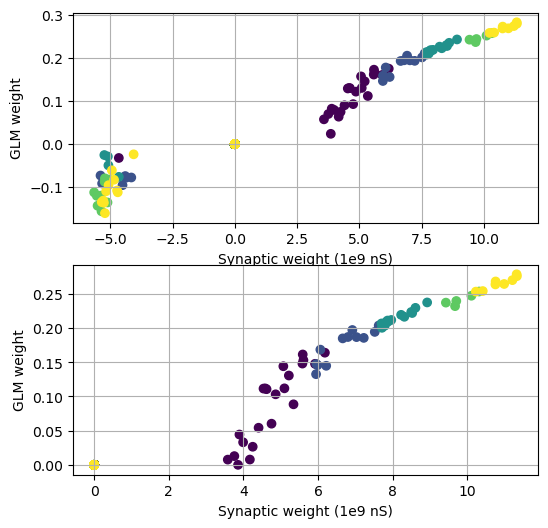

In [31]:
plt.figure(figsize=(6,6))
plt.subplot(211)
plt.scatter(np.hstack([conns[m][:n_PAG_to_use,:] for m in range(len(brain_regions))]), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()

plt.subplot(212)
plt.scatter(np.hstack([conns[m][:n_PAG_to_use,:64] for m in range(len(brain_regions))]), glm_w_exc_only, c=glm_exc_only.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()

plt.show()

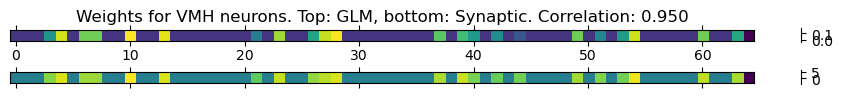

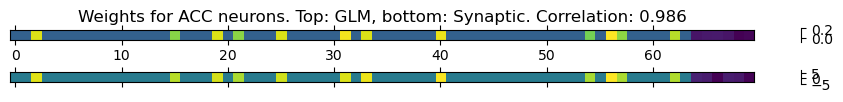

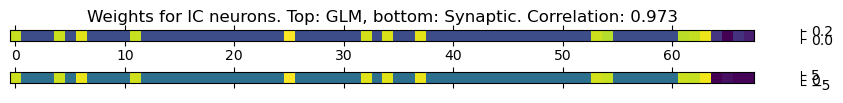

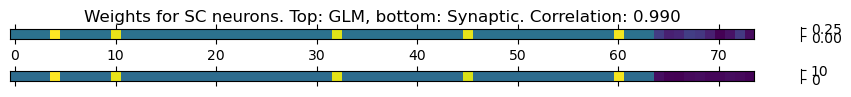

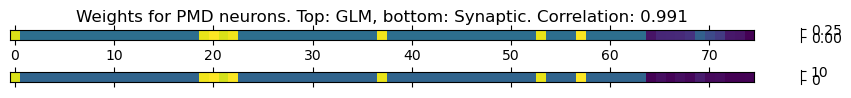

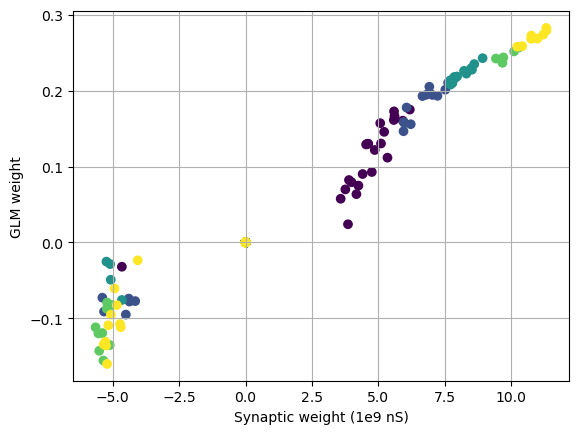

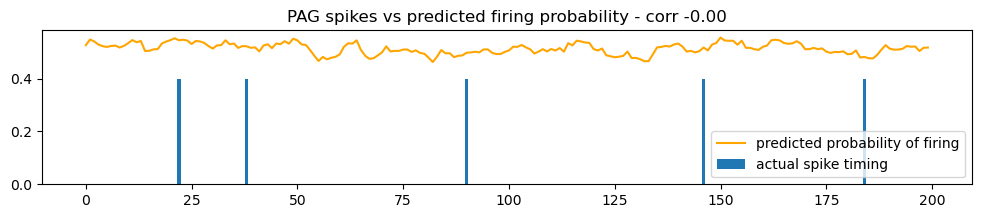

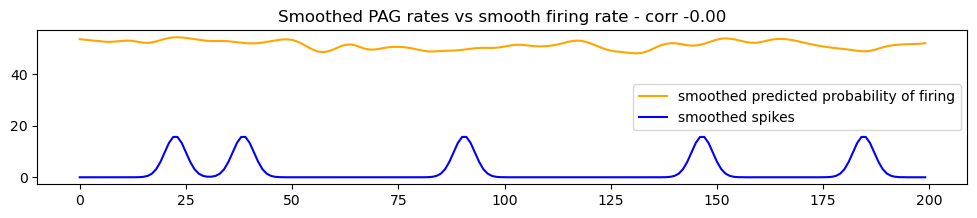

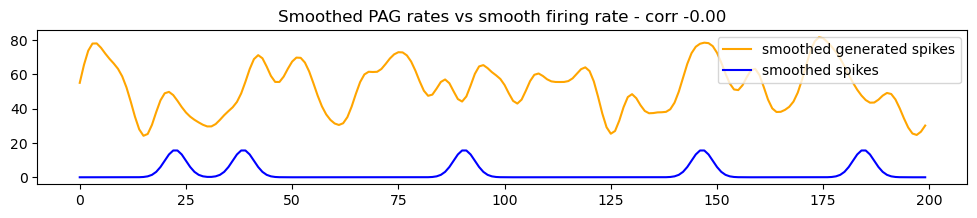

In [11]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=n_neurons_per_group,
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':10,
                'weights_sparsity':10,
               }, # type: ignore
    ).to(device)
# glm.linear.weight.data = torch.as_tensor(glm_w).to(device)
# glm.linear.weight.bias = torch.as_tensor(glm_b).to(device)
# glm.fit(X_train.T.to_dense(), y_train.T.to_dense(), n_iter=2, lr=1e-3, verbose=1, decay=0.9999)
# glm.best_weight, glm.best_bias = glm_w, glm_b
# glm.load_best_params()

# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]].reshape(n_PAG_to_use,-1), conns[m][:n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m][:n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(np.hstack([conns[m][:n_PAG_to_use,:] for m in range(len(brain_regions))]), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.to_dense().T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test.to_dense().cpu()[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test.to_dense().cpu(), y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test.to_dense().cpu()[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

GLM with history filter

In [9]:
from numpy import source


n_PAG_to_use = 16 # specify how many PAG neurons to learn

pag_df = extract_sim_as_df(source_folder, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2024-01-18 15:58:48.531 | DEBUG    | utils:bin_spikes:64 - Created spike bin matrix with 16 neurons and 600000 bins. Total number of spikes: 314871.0


Average PAG firing rate: 32.7990625 Hz.


In [15]:
train_start = 0
train_end = 550
test_start = 550
test_end = 600
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = torch.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)).to_sparse(), torch.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins)).to_sparse()
y_train, y_test = torch.zeros((1, train_bins * n_PAG_to_use)).to_sparse(), torch.zeros((1, test_bins * n_PAG_to_use)).to_sparse()

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

KeyboardInterrupt: 

In [10]:
https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html

TypeError: Cannot assign to a sparse tensor

In [7]:
from glm import BernoulliGLMwHistoryMultiSessionPyTorch
history = 10
weights_within_group_reg = 10
weights_sparsity_reg = 10
glm = BernoulliGLMwHistoryMultiSessionPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=n_neurons_per_group_exc_ihn,
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':weights_within_group_reg,
                'weights_sparsity':weights_sparsity_reg
               }, # type: ignore
    history=history,
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}{str(n_PAG_to_use)}pag_{str(history)}hist_550sec_mark1.pth'))
glm.fit(X_train.to_dense().T, y_train.to_dense().T, n_iter=50000, lr=2*1e-3, verbose=2, decay=0.9999, batch_size=-1)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}{str(n_PAG_to_use)}pag_{str(history)}hist_550sec_regs_{weights_within_group_reg}_{weights_sparsity_reg}.pth')

2024-01-17 18:12:23.817 | INFO     | glm:fit:339 - Data stored in RAM.
2024-01-17 18:12:23.819 | INFO     | glm:fit:344 - Detected dense Tensor.
2024-01-17 18:12:23.820 | INFO     | glm:fit:355 - Training with 1 of batch size 550000.
2024-01-17 18:12:24.254 | DEBUG    | glm:fit:360 - Training GLM with PyTorch. Initial log like: 385365.8125, loss 385456.5, of which regs [0.44725993, 90.2393, 0.0] respectively for ['weights_within_group', 'weights_sparsity', 'beta'].
2024-01-17 18:12:25.117 | DEBUG    | glm:fit:399 - Step 1. Log like: -363169.03125,  loss: 385365.8125
2024-01-17 18:12:25.920 | DEBUG    | glm:fit:399 - Step 2. Log like: -342283.65625,  loss: 363259.8125
2024-01-17 18:12:26.737 | DEBUG    | glm:fit:399 - Step 3. Log like: -322604.03125,  loss: 342374.8125
2024-01-17 18:12:27.564 | DEBUG    | glm:fit:399 - Step 4. Log like: -304107.3125,  loss: 322695.78125
2024-01-17 18:12:28.370 | DEBUG    | glm:fit:399 - Step 5. Log like: -286763.53125,  loss: 304199.9375
2024-01-17 18:1

In [8]:
torch.save(glm.state_dict(), f'{sim_data_path}{str(n_PAG_to_use)}pag_{str(history)}hist_550sec_mark1.pth')

In [8]:
history_filters = glm.history_filters
linear = glm.linear

In [9]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
history_filter_weights = glm.get_history_filter_weights()
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-7.006875]
y-intercept: [0.00090481]


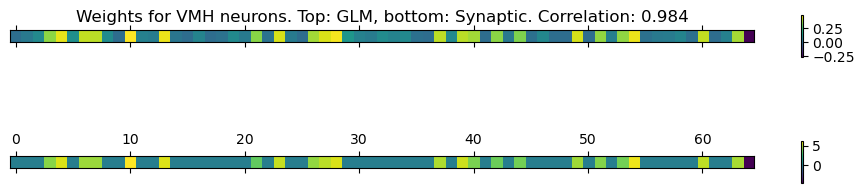

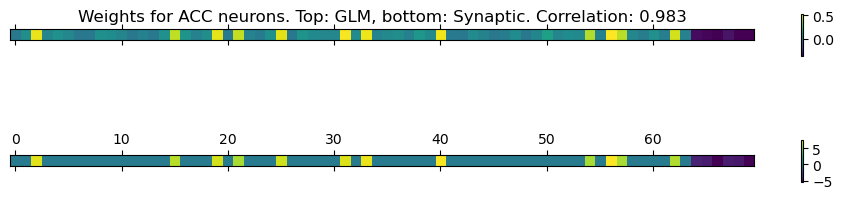

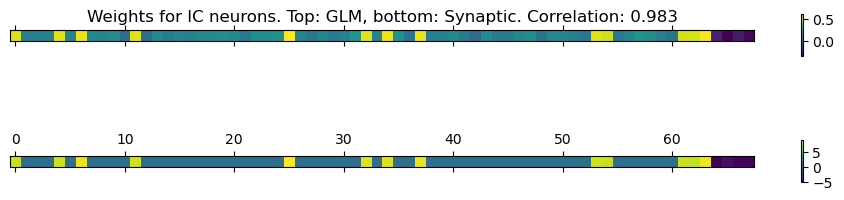

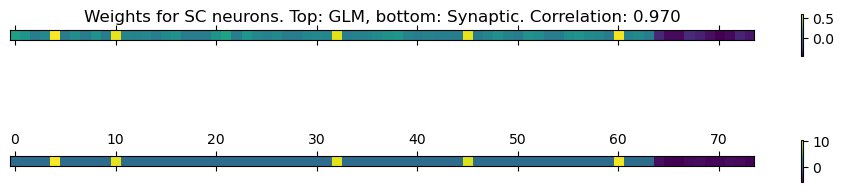

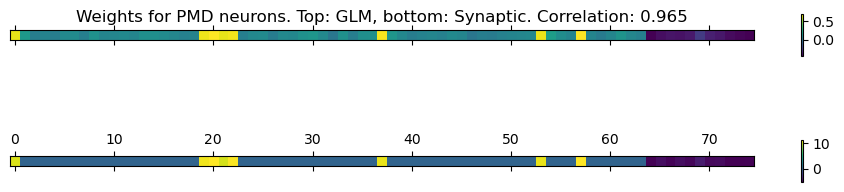

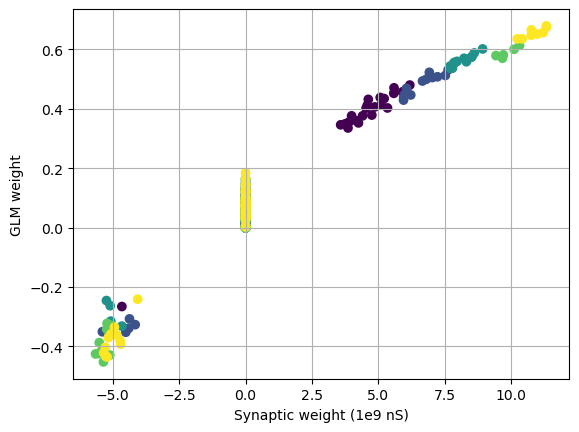

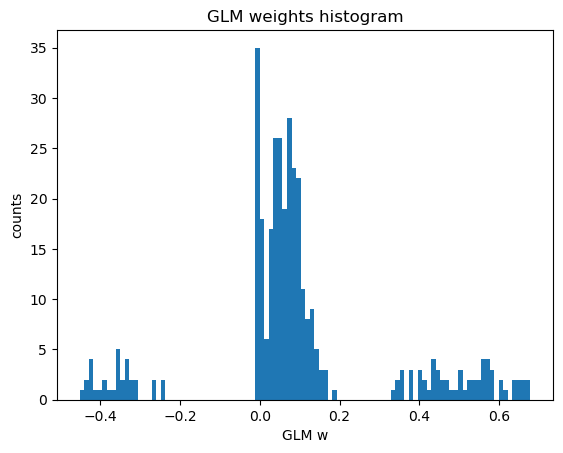

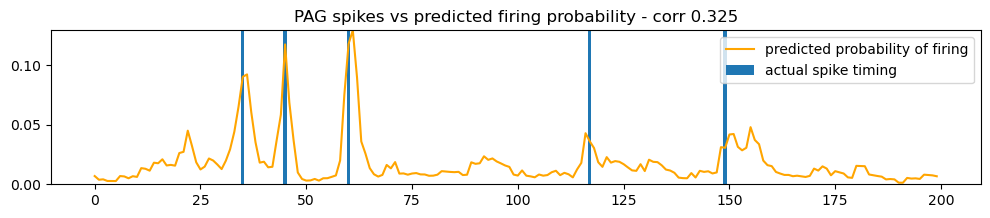

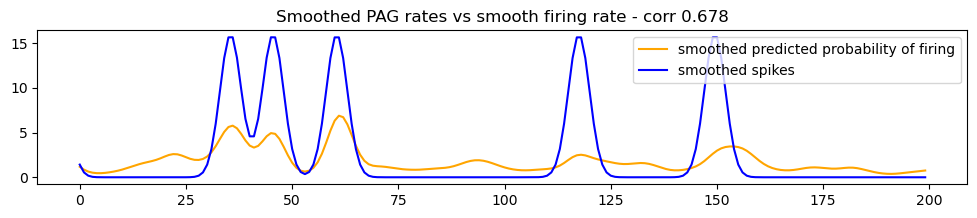

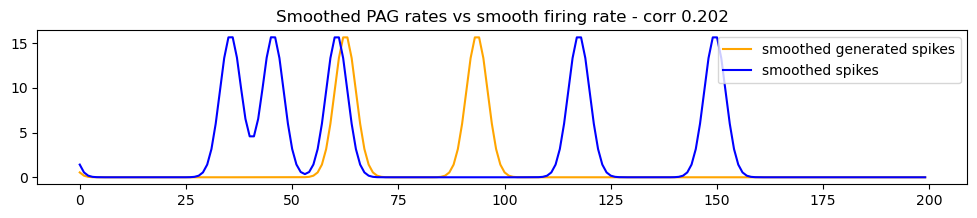

In [22]:

glm = BernoulliGLMwHistoryMultiSessionPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=n_neurons_per_group,
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    regs = ['weights_within_group',
            'weights_sparsity'],
    reg_params={'weights_within_group':weights_within_group_reg,
                'weights_sparsity':weights_sparsity_reg,
               },
    history=history,
    ).to(device)

glm.linear = linear
glm.history_filters = history_filters


# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m][:n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m][:n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(np.hstack([conns[m][:n_PAG_to_use,:] for m in range(len(brain_regions))]), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.to_dense().to(device).T).T # (1 PAG neuron * 50 secs)
    
_range = 200 #ms
_random_start = np.random.randint(55000-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test.to_dense().cpu()[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.ylim([0, torch.max(y_test_hat[0,_random_start:_random_start + _range].cpu())])
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test.to_dense().cpu(), y_test_hat.cpu())[0,1])[:5]}')
plt.show()


generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test.to_dense().cpu()[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

In [27]:
with torch.no_grad():
    print(glm.forward(X_train.T.cuda().to_dense()[0:1,:]))

tensor([[0.0009]], device='cuda:0')


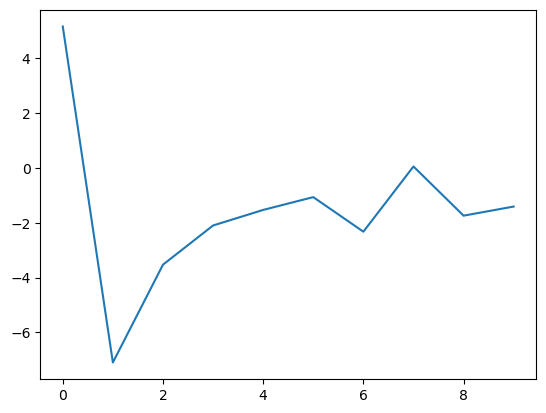

In [14]:
plt.plot(glm.get_history_filter_weights()[0].cpu())